In [1]:
import numpy as np

import os, sys

project_root = os.path.abspath('/Users/subhojit/workspace/saturn/src')
if project_root not in sys.path:
    sys.path.append(project_root)

from lstm.lstm_raw import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Implements the missing generate_dataset function used in training loop

def generate_dataset(seq_len, input_size, num_samples):
    X = []
    Y = []
    for _ in range(num_samples):
        x_seq = [np.random.rand(input_size, 1) for _ in range(seq_len)]
        total = sum(x.sum() for x in x_seq)
        threshold = 0.5 * seq_len * input_size  # average value threshold
        label = np.random.randint(low=0, high=2)
        X.append(x_seq)
        Y.append(label)
    return X, Y

# Let's test it with a small dataset
sample_X, sample_Y = generate_dataset(seq_len=5, input_size=4, num_samples=3)
(sample_X[0][0].shape, sample_Y)


((4, 1), [0, 1, 1])

In [3]:
def clip_gradients(grads, max_norm=5.0):
    total_norm = 0.0
    for g in grads.values():
        total_norm += np.sum(g ** 2)
    total_norm = np.sqrt(total_norm)

    if total_norm > max_norm:
        for k in grads:
            grads[k] = grads[k] * (max_norm / total_norm)
    return grads

In [5]:
# Functions
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0, keepdims=True)

def cross_entropy_loss(y_pred, y_true_idx):
    return -np.log(y_pred[y_true_idx, 0])

def cross_entropy_grad(y_pred, y_true_idx):
    grad = y_pred.copy()
    grad[y_true_idx] -= 1
    return grad

# Training
input_size = 4
hidden_size = 16
output_size = 2
seq_len = 5
lr = 0.1

layer = LSTMLayer(input_size, hidden_size, output_size)
X_train, Y_train = generate_dataset(seq_len, input_size, 100)
lossi = []
# Training loop
for epoch in range(1000):
    total_loss = 0
    correct = 0

    for x_seq, y_true in zip(X_train, Y_train):
        h0 = np.zeros((hidden_size, 1))
        c0 = np.zeros((hidden_size, 1))

        # 1. Forward pass
        outputs = layer.forward(x_seq, h0, c0)

        dy_list = []
        loss = 0
        for t in range(seq_len):
            y_logits, _, _ = outputs[t]
            y_probs = softmax(y_logits)
            loss += cross_entropy_loss(y_probs, y_true)
            dy = cross_entropy_grad(y_probs, y_true)
            dy_list.append(dy)

        total_loss += loss

        # 6. Backward pass
        grads, dWy, dby = layer.backward(dy_list)
        clip_gradients(grads, max_norm=5.0)

        # 7. Parameter update
        layer.update_parameters(grads, dWy, dby, lr)

        # # Accuracy
        # y_pred_class = np.argmax(y_prob)
        # correct += int(y_pred_class == y_true)
    lossi.append(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


KeyboardInterrupt: 

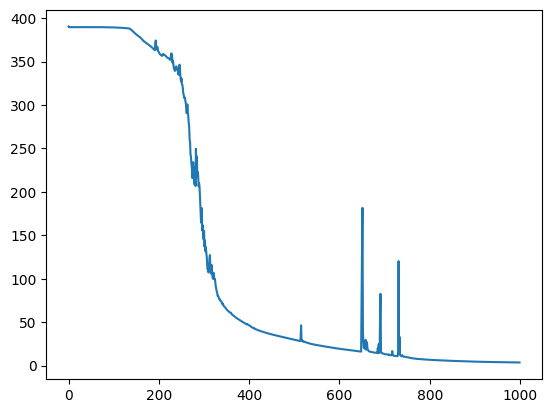

In [6]:
plt.plot(lossi)